# Contexte : Home Credit Default Risk Competition

Pour accorder un crédit à la consommation, l’entreprise souhaite mettre en œuvre un outil de “scoring crédit” qui calcule la probabilité qu’un client le rembourse ou non, puis classifie la demande : crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification pour aider à décider si un prêt peut être accordé à un client.

Les chargés de relation client seront les utilisateurs de l’outil de scoring. Puisqu’ils s’adressent aux clients, ils ont besoin que votre modèle soit facilement interprétable. Les chargés de relation souhaitent, en plus, disposer d’une mesure de l’importance des variables qui ont poussé le modèle à donner cette probabilité à un client.


# Data
Les données sont fournies par Home Credit, un service dédié aux crédits à la population.

Il y a 7 sources de données différentes :

* application_train\application_test : les données principales d'entraînement et de test avec des informations sur chaque demande de prêt chez Home Credit. Chaque prêt a sa propre ligne et est identifié par la caractéristique SK_ID_CURR. Les données de demande d'application d'entraînement sont accompagnées de la TARGET indiquant 0 : le prêt a été remboursé ou 1 : le prêt n'a pas été remboursé.
* bureau : données concernant les crédits précédents des clients provenant d'autres institutions financières. Chaque crédit précédent a sa propre ligne dans le bureau, mais un prêt dans les données de demande peut avoir plusieurs crédits précédents.
* bureau_balance : données mensuelles sur les crédits précédents dans le bureau. Chaque ligne est un mois d'un crédit précédent, et un seul crédit précédent peut avoir plusieurs lignes, une pour chaque mois de la durée du crédit.
* previous_application : demandes précédentes de prêts chez Home Credit de clients ayant des prêts dans les données de demande. Chaque prêt actuel dans les données de demande peut avoir plusieurs prêts précédents. Chaque demande précédente a une ligne et est identifiée par la caractéristique SK_ID_PREV.
* POS_CASH_BALANCE : données mensuelles sur les précédents points de vente ou prêts en espèces que les clients ont eus avec Home Credit. Chaque ligne est un mois d'un précédent point de vente ou prêt en espèces, et un seul prêt précédent peut avoir de nombreuses lignes.
* credit_card_balance : données mensuelles sur les anciennes cartes de crédit que les clients ont eues avec Home Credit. Chaque ligne est un mois d'un solde de carte de crédit, et une seule carte de crédit peut avoir de nombreuses lignes.
* installments_payment : historique des paiements pour les prêts précédents chez Home Credit. Il y a une ligne pour chaque paiement effectué et une ligne pour chaque paiement manqué.


Les définitions des variables sont disponibles dans `HomeCredit_columns_description.csv`

Dans ce notebook nous n'utiliserons que le fichier principal "application_train".

Ce travail est basé sur le kernet préconisé : l start-here-a-gentle-introduction (kaggle)


## Imports
Nous utiliserons les library standard de datascience : `numpy`, `pandas`, `sklearn`, `matplotlib`. 

In [27]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform
import xgboost as xgb
from sklearn import svm
# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE 


pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [28]:
def inspect_dupes(df, dedupe=False):
    '''
    Checks duplicates (rows), and gets rid of duplicates if dedupe arg set to 'True' 
    Arg: dataframe, dedupe (bool)
    '''
    num_of_dupe = len(df[df.duplicated()])

    if dedupe and num_of_dupe>0: 
        df.drop_duplicates(inplace=True)
        print(f'Number of duplicates found: {num_of_dupe}')
        return df

    else: 
        print(f'Number of duplicates found: {num_of_dupe}')
        return num_of_dupe
    
def iqr(df,drop=False):
   
    cols_to_keep = [col for col in df.columns if df[col].nunique() > 2]
    dataframe = df[cols_to_keep]
    
    iqr_analysis_list = []

    # Sélection des variables numériques
    numeric_variables = dataframe.select_dtypes(include=['number'])
    l_ind_outlier=[]
    
    for variable_name in numeric_variables.columns:
        # Calcul de l'analyse IQR pour chaque variable numérique
        variable_data = dataframe[variable_name]
        
        # Calcul des quartiles
        Q1 = variable_data.quantile(0.25)
        Q3 = variable_data.quantile(0.75)
        
        # Calcul de l'IQR (Interquartile Range)
        IQR = Q3 - Q1
        
        # Détermination des limites inférieure et supérieure pour détecter les valeurs aberrantes
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Exclusion des individus aberrants
        excluded_count = ((variable_data < lower_bound) | (variable_data > upper_bound)).sum()
        
        # Calcul du ratio d'exclusion
        total_count = len(variable_data)
        exclusion_ratio = excluded_count / total_count
        
        # Ajout des résultats dans une liste
        iqr_analysis_list.append({
            'Variable': variable_name,
            'Q1': Q1,
            'Q3': Q3,
            'IQR': IQR,
            'Lower Bound': lower_bound,
            'Upper Bound': upper_bound,
            'Excluded Count': excluded_count,
            'Exclusion Ratio': exclusion_ratio
        })

        # Filtrer les valeurs en dehors des bornes IQR
        l_ind_outlier += dataframe[(dataframe[variable_name] <= lower_bound) |
                                   (dataframe[variable_name] >= upper_bound)].index.to_list()

    l_ind_outlier=set(l_ind_outlier)
    print(len(l_ind_outlier))
    
    if drop == True :
        dataframe=dataframe.drop(l_ind_outlier,axis=0)
    # Création d'un dataframe à partir de la liste des résultats
    iqr_analysis_df = pd.DataFrame(iqr_analysis_list)
    display(iqr_analysis_df.sort_values(by='Exclusion Ratio',ascending=False))
    
    return dataframe    
    
    
 # Réduit le nombre de décimale
def format_value(x):
    try:
        return f"{x:.2f}"
    except:
        return str(x)
    
  # Explorations de base du df  
def desc(df):
    print( '************************************')  
    print( '      Descriptif du dataset')
    print( '************************************')  
    print(f'Le dataset est composé de {df.shape[0]} individus et {df.shape[1]} variables.')
    display(df.head())
    display(df.dtypes)
    display(df.describe())
    display(bilan_null(df).sort_values(by='Missing ratio',ascending = True))

  # Renvoie un df avec les Nunique et des infos sur les NaN      
def bilan_null(df):
    df_bilan=pd.concat([df.nunique(),
                        df.isnull().mean(),
                        df.isnull().sum(),
                        df.notnull().sum()],
                        axis=1,
                        keys=['Nunique','Missing ratio','Null count','Notnull count'])
    return df_bilan.sort_values(by='Missing ratio')

# Fonction pour encoder les variables catégorielles
def cat_enc(df) :

    le = LabelEncoder()
    le_count = 0

    # Iterate through the columns
    for col in df:
        if df[col].dtype == 'object':
            # If 2 or fewer unique categories
            if len(list(df[col].unique())) <= 2:
                # Train on the training data
                le.fit(df[col])
                # Transform both training and testing data
                df[col] = le.transform(df[col])
                # Keep track of how many columns were label encoded
                le_count += 1

    print('%d columns were label encoded.' % le_count)
    # one-hot encoding of categorical variables
    df = pd.get_dummies(df,dtype=int)

    print('Training Features shape: ', df.shape)
    
    return df
def plot_target_cat(df, cat):

        plt.figure(figsize=(10, 6))
        sns.countplot(x=cat, hue="TARGET", data=df)
        plt.title("Effectifs de {} par {}".format(cat, "TARGET"))
        plt.xlabel(cat)
        if max([len(str(i)) for i in df[cat].unique()]) > 15:
            plt.xticks(rotation=45)
        if max([len(str(i)) for i in df[cat].unique()]) > 20:
            plt.xticks(rotation=90)
        plt.ylabel("Effectifs")
        plt.legend(title="TARGET", loc='upper right')
        plt.show()
        raw_df.groupby(cat)["TARGET"].mean().plot(kind='bar')    
        plt.title("Moyenne de défaut de paiement")
        if max([len(str(i)) for i in df[cat].unique()]) < 15:
            plt.xticks(rotation=0)
        if max([len(str(i)) for i in df[cat].unique()]) > 15:
            plt.xticks(rotation=45)
        if max([len(str(i)) for i in df[cat].unique()]) > 20:
            plt.xticks(rotation=90)
        plt.show()

def plot_target_num(df, numerical_column):

    # Création des bins
    df['bins'] = pd.cut(df[numerical_column], bins=11,precision=0)
    # Calcul de la moyenne de la cible pour chaque bin
    mean_target = df.groupby('bins')["TARGET"].mean()

    plt.figure(figsize=(10, 6))
    sns.countplot(x=df['bins'], hue="TARGET", data=df)
    plt.title("Effectifs de {} par {}".format(numerical_column, "TARGET"))
    plt.xlabel(numerical_column)
    if max([len(str(i)) for i in df[numerical_column].unique()]) > 15:
        plt.xticks(rotation=45)
    if max([len(str(i)) for i in df[numerical_column].unique()]) > 20:
        plt.xticks(rotation=90)
    plt.ylabel("Effectifs")
    plt.legend(title="TARGET", loc='upper right')
    plt.show()    
        
    
    # Tracé du barplot
    plt.figure(figsize=(10, 6))
    mean_target.plot(kind='bar')
    plt.title("Moyenne de défaut de paiement")
    plt.xlabel(numerical_column)
    plt.ylabel(('%'))
    if max([len(str(i)) for i in df[numerical_column].unique()]) > 15:
        plt.xticks(rotation=45)
    if max([len(str(i)) for i in df[numerical_column].unique()]) > 20:
        plt.xticks(rotation=90)
    plt.show()        

def plot_roc_curves(y_true, d_res):

    plt.figure(figsize=(8, 6))
    for label in d_res :
        print(label)
        print(y_true.shape)
        print(d_res[label][2][:,1].shape)
        if label != 'DummyClassifier' :
            fpr, tpr, _ = roc_curve(y_true, d_res[label][2][:,1])
            auc = roc_auc_score(y_true, d_res[label][2][:,1])
            plt.plot(fpr, tpr, label=f'{label} (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('Taux de faux positifs (FPR)')
    plt.ylabel('Taux de vrais positifs (TPR)')
    plt.title('Courbes ROC')
    plt.legend()
    plt.show()
    
def make_confusion_matrix(y_true,
                          y_pred,
                          y_pred_proba=0,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    
    group_names = ['True Neg','False Pos','False Neg','True Pos']

    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''

    cf=confusion_matrix(y_true, y_pred)

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks
    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks
    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks
    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        # if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            # Metrics for Binary Confusion Matrices
            precision = cf[1,1] / np.sum(cf[:,1])
            recall    = cf[1,1] / np.sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            HC_score  = custom_cost(y_true,y_pred)
            auc       = roc_auc_score(y_true, y_pred_proba)
            stats_text = '''
           
HC Score  = {:0.3f}
Accuracy  = {:0.3f}
Precision = {:0.3f}
Recall    = {:0.3f}
F1 Score  = {:0.3f}
                 
ROC AUC   = {:0.3f}
                        '''.format(
                HC_score, accuracy, precision, recall, f1_score, auc)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

def custom_cost(y_ref, y_pred):
    # Assigner des poids aux erreurs
    FP_cost = 1  # Coût d'un faux positif
    FN_cost = 10   # Coût d'un faux négatif
    TP_cost = 10   # Coût d'un vrai positif
    TN_cost = 10   # Coût d'un faux positif
    
    # Calculer le nombre de faux positifs et de faux négatifs
    FP_count = sum((y_ref == 0) & (y_pred == 1))
    FN_count = sum((y_ref == 1) & (y_pred == 0))
    TP_count = sum((y_ref == 1) & (y_pred == 1))
    TN_count = sum((y_ref == 0) & (y_pred == 0))  
    
    Total_count = y_ref.shape[0]
    
    # Calculer le coût total
    total_cost = (TP_count*TP_cost +  TN_count*TN_cost - FP_count*FP_cost - FN_count*FN_cost)/(TP_count*TP_cost +  TN_count*TN_cost + FP_count*FP_cost + FN_count*FN_cost)
        
    return total_cost

def search_score(titre, model,  param, n_job, X_train, y_train, X_test, y_test) :
   
    clf = model 
    
    param_grid = param

    model_opt = RandomizedSearchCV(clf,
                                   param_grid,
                                   cv=2,
                                   n_iter=200,
                                   verbose=1,
                                   scoring=HC_scorer,
                                   n_jobs=n_job,
                                   random_state=42,
                                   refit=True )
    
    model_opt = model_opt.fit(X_train, y_train)


    fpr, tpr, thr = roc_curve(y_test, model_opt.predict_proba(X_test)[:,1])
    roc_auc = auc(fpr, tpr)
    
    y_true= y_test
    y_pred = model_opt.predict(X_test)
    y_pred_proba = model_opt.predict_proba(X_test)[:,1]
    
    make_confusion_matrix(y_true, y_pred,  y_pred_proba=y_pred_proba)
    
    d_res[titre]=[
                    roc_auc,
                    custom_cost(y_test,model_opt.predict(X_test)),
                    model_opt.predict_proba(X_test)
                   ]    
   
    results = model_opt.cv_results_

    # Créer un DataFrame avec les informations pertinentes
    df_results = pd.DataFrame({
        'rank_test_score': results['rank_test_score'],
        'mean_test_score': results['mean_test_score'],
        'params': results['params']
    })
    # Extraire les paramètres individuels
    params_df = pd.json_normalize(df_results['params'])

    # Combiner les résultats avec les paramètres
    df_results_combined = pd.concat([df_results.drop(columns=['params']), params_df], axis=1)

    # Trier le DataFrame par rang
    df_results_sorted = df_results_combined.sort_values(by='rank_test_score')


    # Afficher les trois meilleurs résultats
    top_5_results = df_results_sorted.head(5)

    # Afficher les résultats sous forme de tableau
    display(top_5_results)
    
    return model_opt

##  Chargement des données

Commençons par visualiser 'application_train.csv' : 

In [29]:
# Training data
raw_df = pd.read_csv('C:\\Users\Cecil\\Desktop\\Formation\\4_Credit_scoring\\data\\application_train.csv')

app_train=raw_df.copy()
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

Les données d'entraînement comprennent 307511 observations (chaque observation correspondant à un prêt distinct) et 122 caractéristiques (variables) incluant la variable TARGET (l'étiquette que nous voulons prédire).

# Analyse exploratoire des données
L'objectif de l'AED est de découvrir ce que nos données peuvent nous apprendre. Elle commence généralement par une vue d'ensemble, puis se concentre sur des domaines spécifiques. Les résultats peuvent par exemple nous aider à décider quelles caractéristiques utiliser pour l'apprentissage du modèle.

## Examiner la distribution de la colonne cible
La cible est soit 0 pour un remboursement à temps du prêt, soit 1 pour des difficultés de paiement. Visualisons la répartition des cibles :

In [30]:
app_train['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

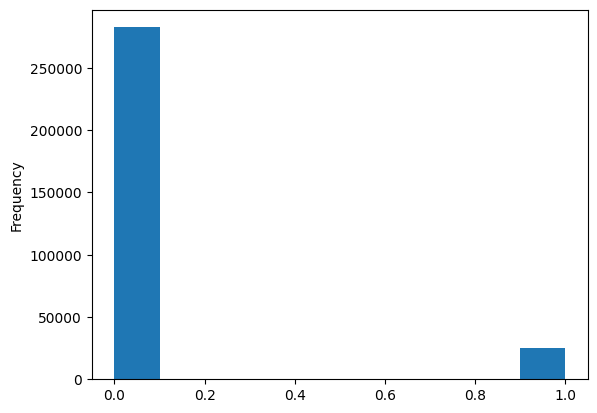

In [31]:
app_train['TARGET'].astype(int).plot.hist()

D'après ces informations, nous constatons qu'il s'agit d'un problème de classes déséquilibrées. Il y a beaucoup plus de prêts qui ont été remboursés à temps que de prêts qui n'ont pas été remboursés.

In [32]:
app_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,12.061091,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.152665,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.502130,5.143927e-01,0.510853,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,0.149725,0.226282,0.231894,0.066333,0.100775,0.107399,0.008809,0.028358,0.114231,0.087543,0.977065,0.759637,0.042553,0.074490,0.145193,0.222315,0.228058,0.064958,0.105645,0.105975,0.008076,0.027022,0.117850,0.087955,0.97

## Valeurs manquantes

Visualisons les données manquantes :

In [33]:
# Function to calculate missing values by column# Funct 
bilan_null(app_train)


,Nunique,Missing ratio,Null count,Notnull count
SK_ID_CURR,307511,0.000000,0,307511
HOUR_APPR_PROCESS_START,24,0.000000,0,307511
REG_REGION_NOT_WORK_REGION,2,0.000000,0,307511
LIVE_REGION_NOT_WORK_REGION,2,0.000000,0,307511
REG_CITY_NOT_LIVE_CITY,2,0.000000,0,307511
REG_CITY_NOT_WORK_CITY,2,0.000000,0,307511
LIVE_CITY_NOT_WORK_CITY,2,0.000000,0,307511
ORGANIZATION_TYPE,58,0.000000,0,307511
FLAG_DOCUMENT_21,2,0.000000,0,307511
FLAG_DOCUMENT_20,2,0.000000,0,307511


Afin de ne pas garder des colonnes inutiles, nous supprimons les colonnes avec plus de 60% de données manquantes :

In [34]:
# Calculer le seuil de nombre de valeurs non nulles
threshold = len(app_train) * 0.4  # 60% de valeurs nulles

# Supprimer les colonnes avec plus de 60% de valeurs nulles
app_train.dropna(axis=1, thresh=threshold, inplace=True)

bilan_null(app_train)

,Nunique,Missing ratio,Null count,Notnull count
SK_ID_CURR,307511,0.000000,0,307511
HOUR_APPR_PROCESS_START,24,0.000000,0,307511
REG_REGION_NOT_LIVE_REGION,2,0.000000,0,307511
LIVE_REGION_NOT_WORK_REGION,2,0.000000,0,307511
REG_CITY_NOT_LIVE_CITY,2,0.000000,0,307511
REG_CITY_NOT_WORK_CITY,2,0.000000,0,307511
LIVE_CITY_NOT_WORK_CITY,2,0.000000,0,307511
ORGANIZATION_TYPE,58,0.000000,0,307511
FLAG_DOCUMENT_21,2,0.000000,0,307511
FLAG_DOCUMENT_20,2,0.000000,0,307511


## Types des variables

Visualisons à présent le nombre de colonne de chaque type de données : 

In [35]:
# Number of each type of column
app_train.dtypes.value_counts()

float64    49
int64      41
object     15
Name: count, dtype: int64

## Encodage des variables catégorielles

Il existe deux principales façons d'effectuer ce processus :

* Encodage par étiquettes : attribuer à chaque catégorie unique dans une variable catégorielle un entier. Aucune nouvelle colonne n'est créée. 

* Encodage one-hot : créer une nouvelle colonne pour chaque catégorie unique dans une variable catégorielle. Chaque observation reçoit un 1 dans la colonne correspondant à sa catégorie et un 0 dans toutes les autres nouvelles colonnes.

L'encodage par étiquettes présente un inconvénient majeur : il attribue un ordre arbitraire aux catégories. Les valeurs assignées sont aléatoires et ne reflètent aucune caractéristique intrinsèque de la catégorie. Cela peut conduire le modèle à interpréter la valeur relative des caractéristiques pour attribuer des poids, ce qui n'est pas souhaitable. L'encodage one-hot est préférable lorsque nous avons plus de deux catégories uniques, car il évite cet écueil.

Dans ce notebook, nous utiliserons :
* l'encodage par étiquettes pour les variables catégorielles avec seulement 2 catégories
* l'encodage one-hot pour les variables catégorielles avec plus de 2 catégories.

In [36]:


app_train=cat_enc(app_train)


3 columns were label encoded.
Training Features shape:  (307511, 223)


L'encoding des variables catégorielles à créer beaucoup de nouvelles variables.

## Suppression des doublons

Vérifions la présence des doublons sur l'identifiant "SK_ID_CURR" :

In [37]:
raw_df.duplicated(subset="SK_ID_CURR").sum()

0

Il n'y a pas de doublon dans le jeu de données.

## Valeurs abérrantes

Un problème auquel nous voulons toujours être attentif lors de l'analyse exploratoire des données est la présence de valeurs abérrantes dans les données. Celles-ci peuvent être dues à des nombres mal saisis, à des erreurs dans les équipements de mesure, ou elles pourraient être valides mais des mesures extrêmes.  

Analysons les éventuels outliers avec la méthode des intervales interquartiles :

In [38]:
iqr(raw_df)

307511


,Variable,Q1,Q3,IQR,Lower Bound,Upper Bound,Excluded Count,Exclusion Ratio
13,REGION_RATING_CLIENT,2.000000,2.000000,0.000000,2.000000,2.000000e+00,80527,0.261867
14,REGION_RATING_CLIENT_W_CITY,2.000000,2.000000,0.000000,2.000000,2.000000e+00,78027,0.253737
8,DAYS_EMPLOYED,-2760.000000,-289.000000,2471.000000,-6466.500000,3.417500e+03,72217,0.234844
71,AMT_REQ_CREDIT_BUREAU_QRT,0.000000,0.000000,0.000000,0.000000,0.000000e+00,50575,0.164466
70,AMT_REQ_CREDIT_BUREAU_MON,0.000000,0.000000,0.000000,0.000000,0.000000e+00,43759,0.142301
63,DEF_30_CNT_SOCIAL_CIRCLE,0.000000,0.000000,0.000000,0.000000,0.000000e+00,35166,0.114357
65,DEF_60_CNT_SOCIAL_CIRCLE,0.000000,0.000000,0.000000,0.000000,0.000000e+00,25769,0.083799
62,OBS_30_CNT_SOCIAL_CIRCLE,0.000000,2.000000,2.000000,-3.000000,5.000000e+00,19971,0.064944
64,OBS_60_CNT_SOCIAL_CIRCLE,0.000000,2.000000,2.000000,-3.000000,5.000000e+00,19564,0.063620
46,NONLIVINGAREA_MODE,0.000000,0.023100,0.023100,-0.034650,5.775000e-02,18817,0.061191


,SK_ID_CURR,CODE_GENDER,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,M,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,Laborers,1.0,2,2,WEDNESDAY,10,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.0220,0.0198,0.0,0.0000,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.0000,reg oper account,block of flats,0.0149,"Stone, brick",2.0,2.0,2.0,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,F,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,Core staff,2.0,1,1,MONDAY,11,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.0790,0.0554,0.0,0.0000,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.0100,reg oper account,block of flats,0.0714,Block,1.0,0.0,1.0,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,M,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,Laborers,1.0,2,2,MONDAY,9,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,F,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,Laborers,2.0,2,2,WEDNESDAY,17,Business Entity Type 3,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,M,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,Core staff,1.0,2,2,THURSDAY,11,Religion,NaN,0.322738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

Il existe beaucoup d'outliers d'un point de vue purement statistique. Il va être difficile d'évaluer la qualité des observations puisque la plupart d'entre elles sont normalisées.

Observons les variables d'observation de défaut de paiement du cercle social :

<Axes: >

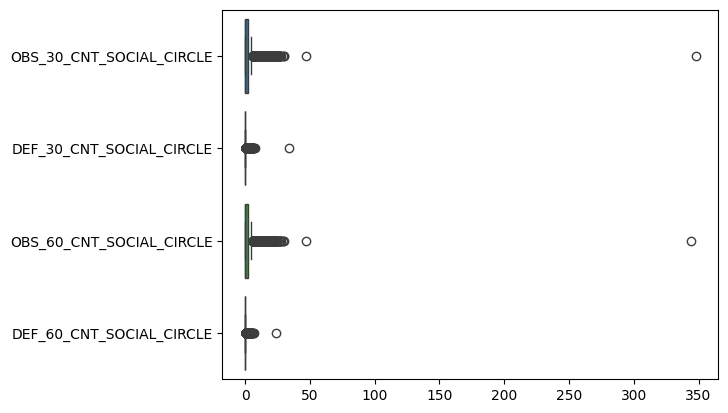

In [39]:
sns.boxplot(orient='h',data=raw_df[['OBS_30_CNT_SOCIAL_CIRCLE','DEF_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE']])               

Les valeurs supérieures à 300 n'ont pas de sens et seront supprimées :

In [40]:
display(raw_df.shape)
raw_df.drop(raw_df[raw_df['OBS_30_CNT_SOCIAL_CIRCLE']>300].index,axis=0,inplace=True)
raw_df.drop(raw_df[raw_df['OBS_60_CNT_SOCIAL_CIRCLE']>300].index,axis=0,inplace=True)
display(raw_df.shape)


(307511, 122)

(307510, 122)

<Axes: >

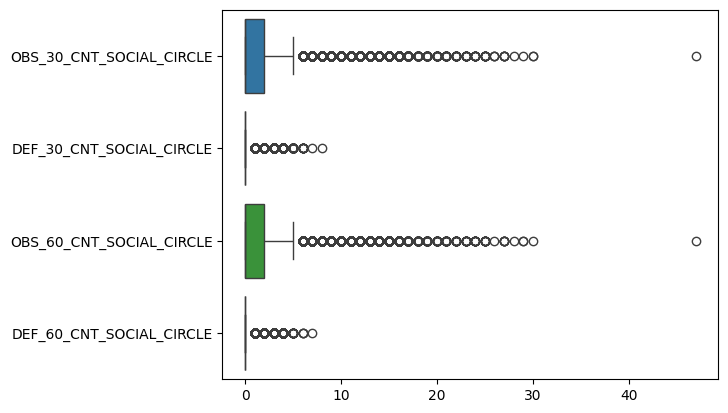

In [41]:
sns.boxplot(orient='h',data=raw_df[['OBS_30_CNT_SOCIAL_CIRCLE','DEF_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE']])               

Visualisons à présent les informations de base sur les crédits : le montant annuel à payer et le montant du crédit :

<Axes: xlabel='AMT_ANNUITY', ylabel='AMT_CREDIT'>

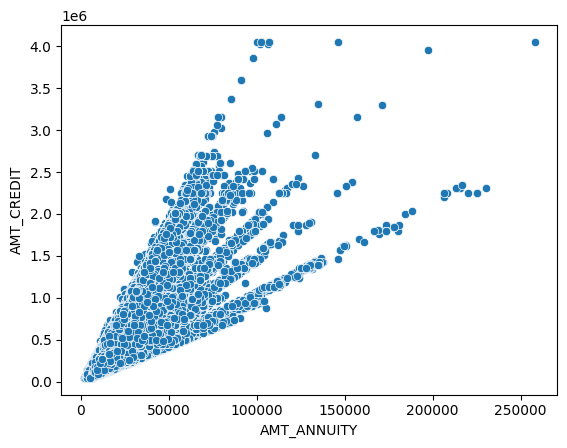

In [42]:
df_annuity_credit=raw_df[['AMT_ANNUITY','AMT_CREDIT','AMT_INCOME_TOTAL']]
sns.scatterplot(data=df_annuity_credit,
                x='AMT_ANNUITY',
                y='AMT_CREDIT')


Les valeurs AMT_CREDIT et ANNUITY ne semblent pas erronées.

Regardons à présent les données temporelles :

In [43]:

col_day=['DAYS_BIRTH', 'DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH','DAYS_LAST_PHONE_CHANGE']
for c in col_day :
    app_train[c]=app_train[c]*-1
    
(app_train[col_day] / 365).describe()

,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE
count,307511.000000,307511.000000,307511.000000,307511.000000,307510.000000
mean,43.936973,-174.835742,13.660604,8.203294,2.637969
std,11.956133,387.056895,9.651743,4.135481,2.265229
min,20.517808,-1000.665753,-0.000000,0.000000,-0.000000
25%,34.008219,0.791781,5.506849,4.712329,0.750685
50%,43.150685,3.323288,12.339726,8.915068,2.073973
75%,53.923288,7.561644,20.491781,11.778082,4.301370
max,69.120548,49.073973,67.594521,19.717808,11.758904


Il semble y avoir une valeur abérantes dans DAYS_EMPLOYED.

La valeur -1000 semble erronnée, entrainant également une moyenne abérrante.

Text(0, 0.5, 'Effectif')

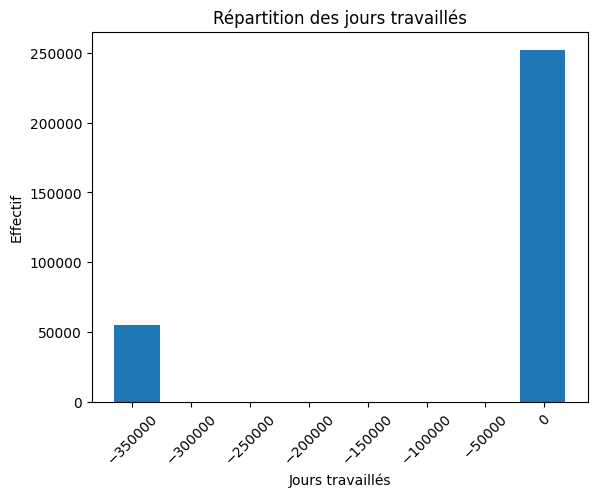

In [44]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Répartition des jours travaillés');
plt.xlabel('Jours travaillés');
plt.xticks(rotation=45)
plt.ylabel("Effectif")


Comme solution, nous remplirons les valeurs anormales avec une valeur non numérique (np.nan).


Text(0, 0.5, 'Effectif')

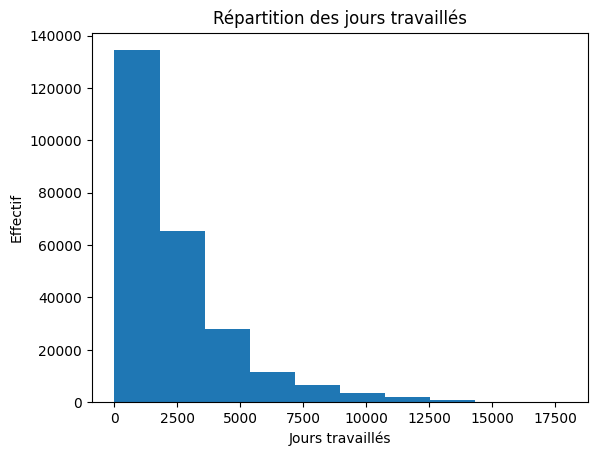

In [45]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == -365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({-365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Répartition des jours travaillés');
plt.xlabel('Jours travaillés')
plt.ylabel("Effectif")


La distribution semble être beaucoup plus conforme à ce que nous attendions. Nous avons également créé une nouvelle colonne pour indiquer au modèle que ces valeurs étaient initialement anormales (parce que nous devrons remplir les NaN avec une valeur, probablement la médiane de la colonne). Les autres colonnes avec DAYS dans le dataframe semblent être à peu près ce que nous attendons, sans valeurs aberrantes évidentes.


### Correlations

Nous allons maintenant calculer le coefficient de corrélation de Pearson entre chaque variable et la cible en utilisant la méthode .corr du dataframe.

In [46]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15).sort_values(ascending=False)[1:])
print('\nMost Negative Correlations:\n', correlations.head(20))

Most Positive Correlations:
 REGION_RATING_CLIENT_W_CITY                          0.060893
REGION_RATING_CLIENT                                 0.058899
NAME_INCOME_TYPE_Working                             0.057481
CODE_GENDER_M                                        0.054713
REG_CITY_NOT_WORK_CITY                               0.050994
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
FLAG_EMP_PHONE                                       0.045982
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_DOCUMENT_3                                      0.044346
OCCUPATION_TYPE_Laborers                             0.043019
LIVE_CITY_NOT_WORK_CITY                              0.032518
DEF_30_CNT_SOCIAL_CIRCLE                             0.032248
DEF_60_CNT_SOCIAL_CIRCLE                             0.031276
OCCUPATION_TYPE_Drivers                              0.030303
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                           -0.17

[Text(0.5, 0, 'Coefficient de correlation')]

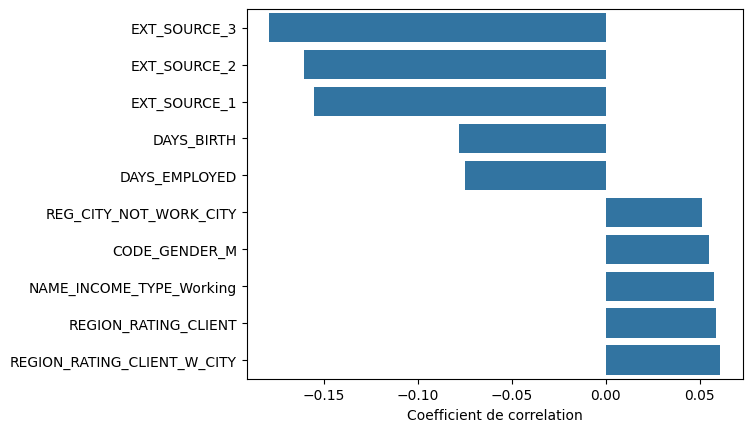

In [47]:
import seaborn as sns 
ax=sns.barplot(pd.concat([correlations.head(5),correlations[:-1].tail(5)]),orient='h')
ax.set(xlabel ="Coefficient de correlation")            
            #'Coefficient de correlation')


REGION_RATING_CLIENT_W_CITY est la corrélation la plus positive. En consultant la documentation, REGION_RATING_CLIENT_W_CITY  est une note de la ville où vit le client. La corrélation est positive, donc plus la note est élevée, plus le client peut avoir des difficultés à rembourser son prêt.

EXT_SOURCE_3 2 et 1 sont les trois caractéristiques avec des corrélations négatives inférieures à -0.1.
Ce score est 'Normalized score from external data source', ce qui ne nous permet pas d'avoir plus d'information sur sa construction. Toutefois, nous pouvons déduire que plus ce score est élevé moins il est susceptible de faire défaut sur son prêt.

DAYS_BIRTH est également corrélé négativement. Donc, plus le client vieillit, moins il est susceptible de faire défaut sur son prêt.

# Répartition des défauts de paiement par type de région

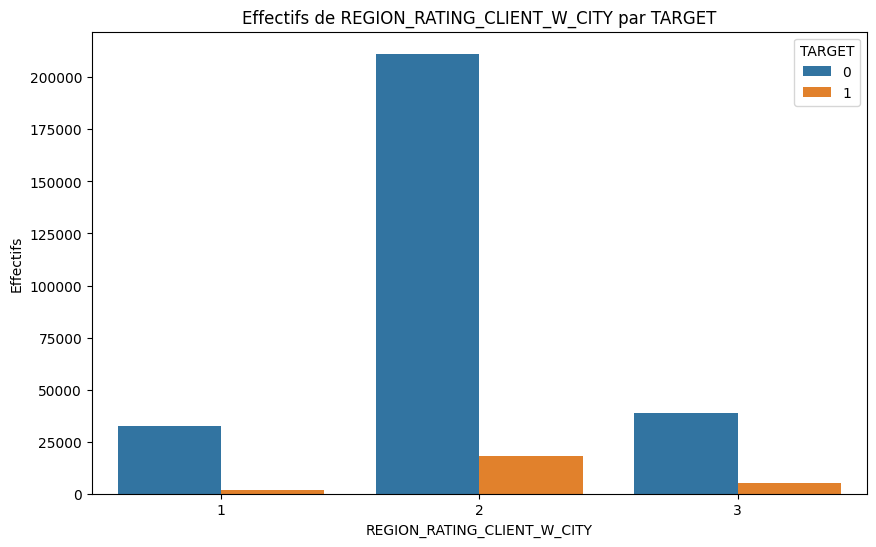

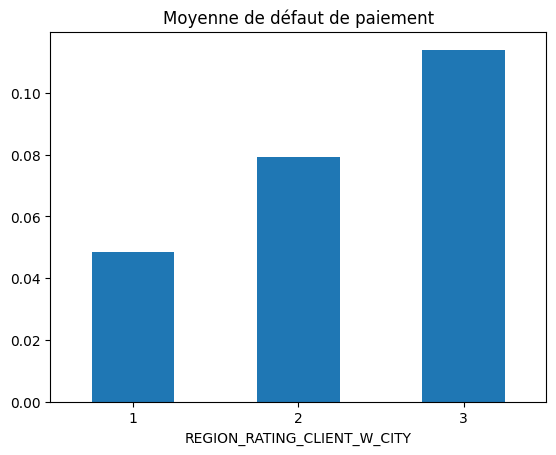

In [48]:
 
plot_target_cat(raw_df,  "REGION_RATING_CLIENT_W_CITY")


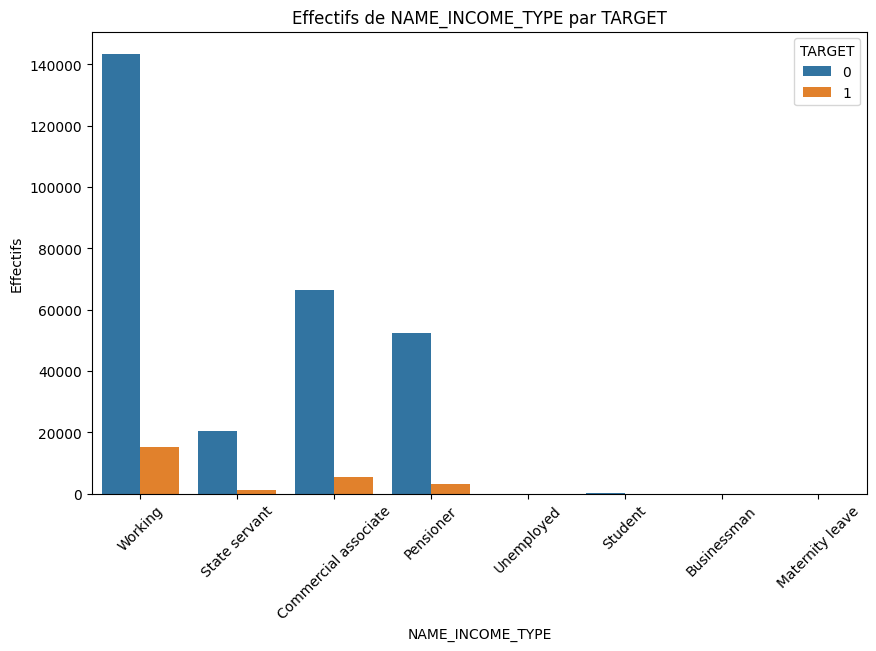

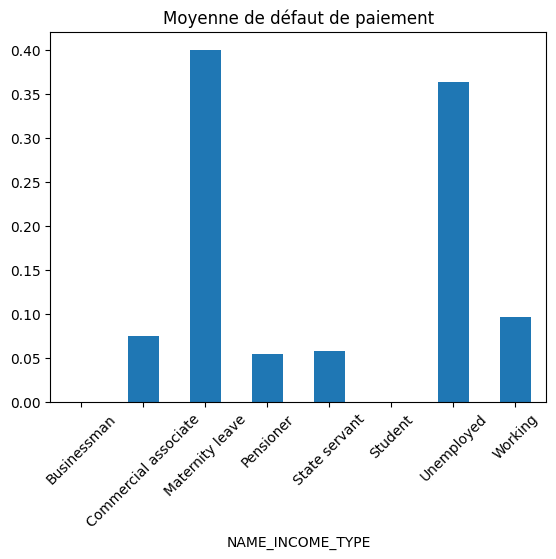

In [49]:
plot_target_cat(raw_df,  "NAME_INCOME_TYPE")


Nous observons que les populations en congé maternité et les personnes sans emplois ont souvent des difficultés de paiement.

# Répartition des défauts de paiement par EXT_SOURCE_3


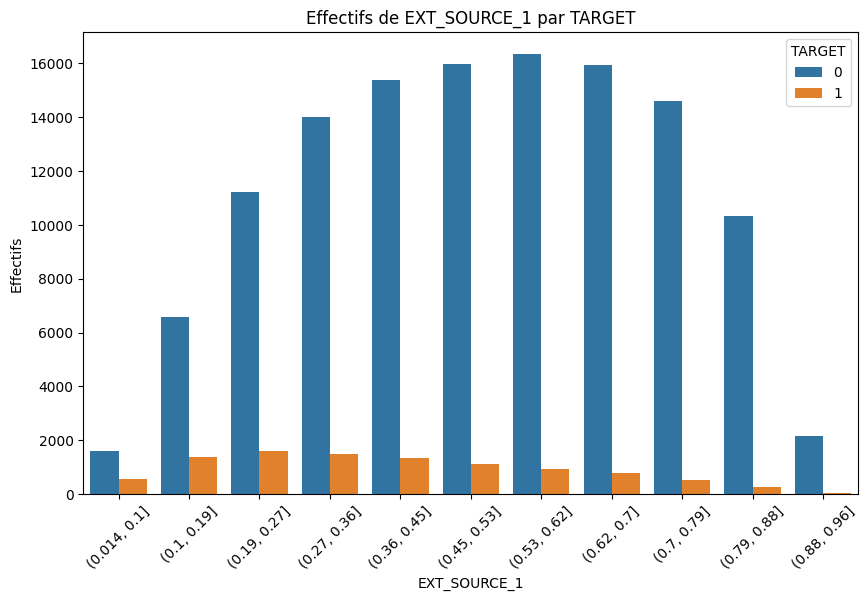

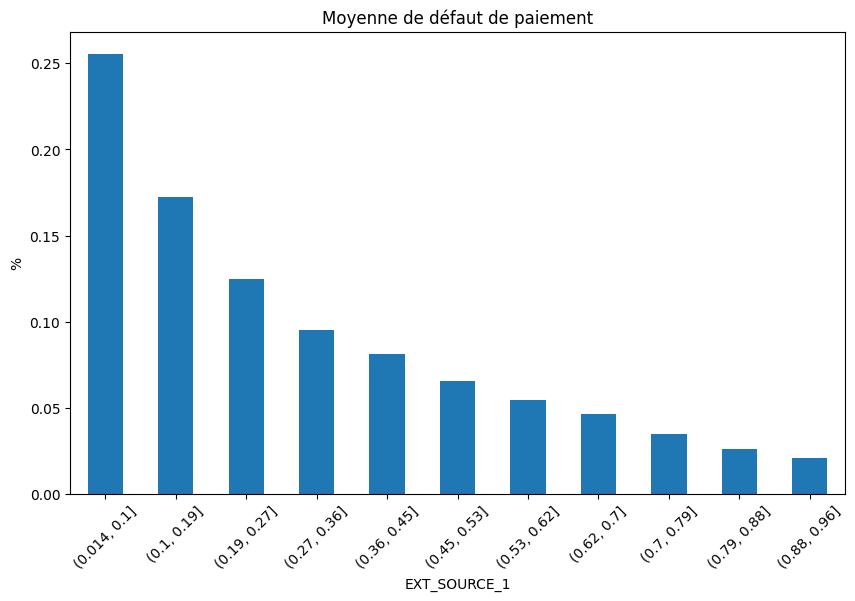

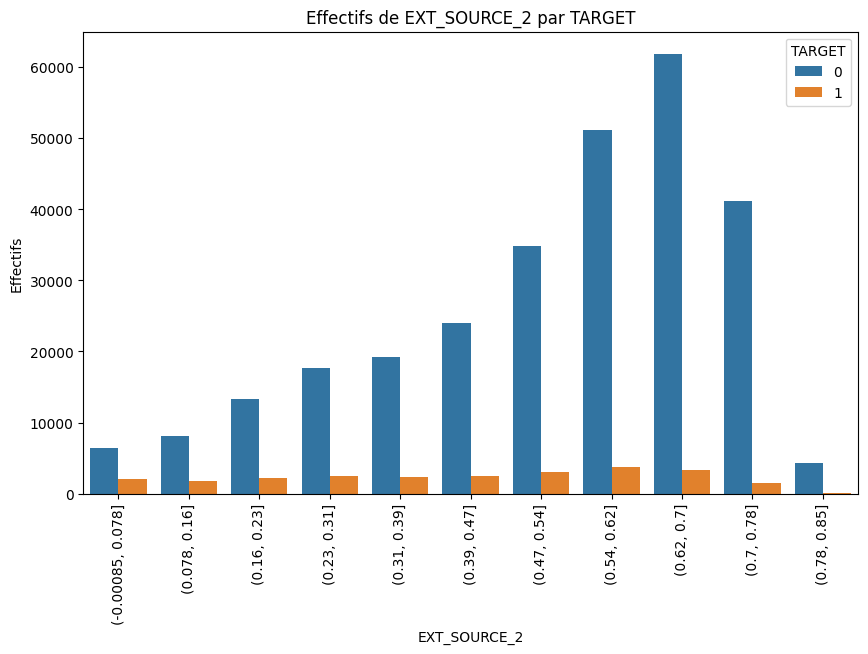

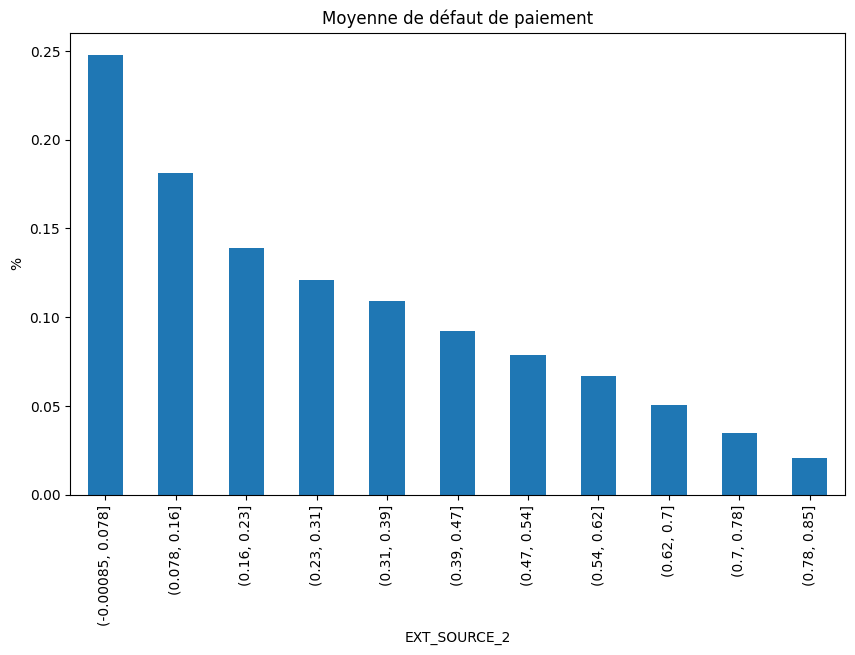

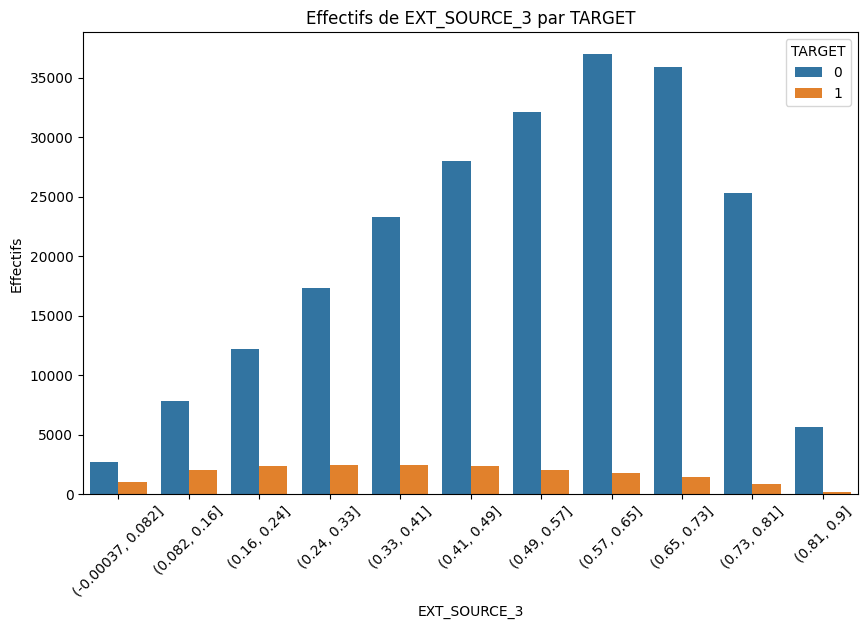

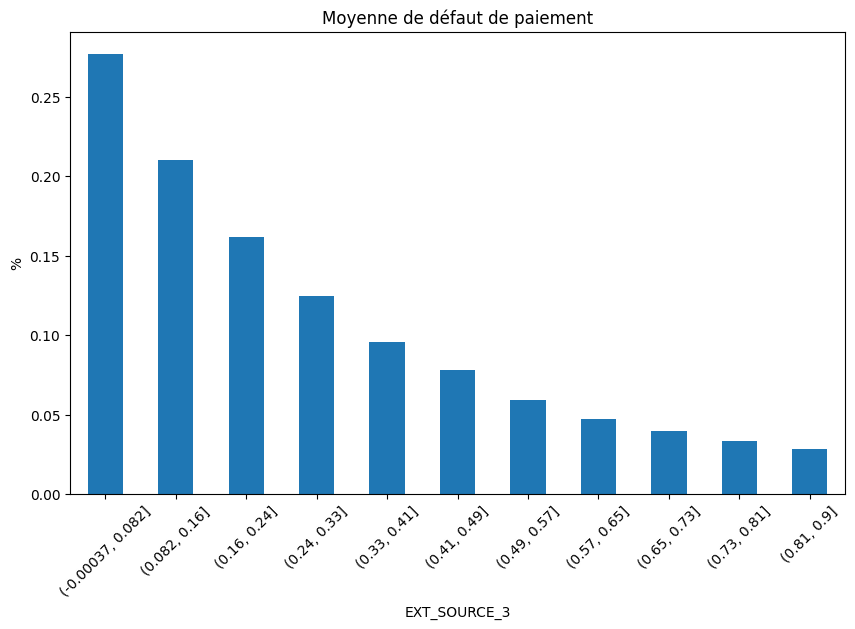

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt


# Utilisation de la fonction avec un DataFrame 'df', une colonne numérique 'numerical_column' et une colonne cible 'target_column'
plot_target_num(raw_df, 'EXT_SOURCE_1')
plot_target_num(raw_df, 'EXT_SOURCE_2')
plot_target_num(raw_df, 'EXT_SOURCE_3')


Nous observons les mêmes tendances sur les 3 EXT_SOURCE. Plus la valeur augmente et moins il y a de risque de défaut de paiement.

# Répartition des défauts de paiement par âge

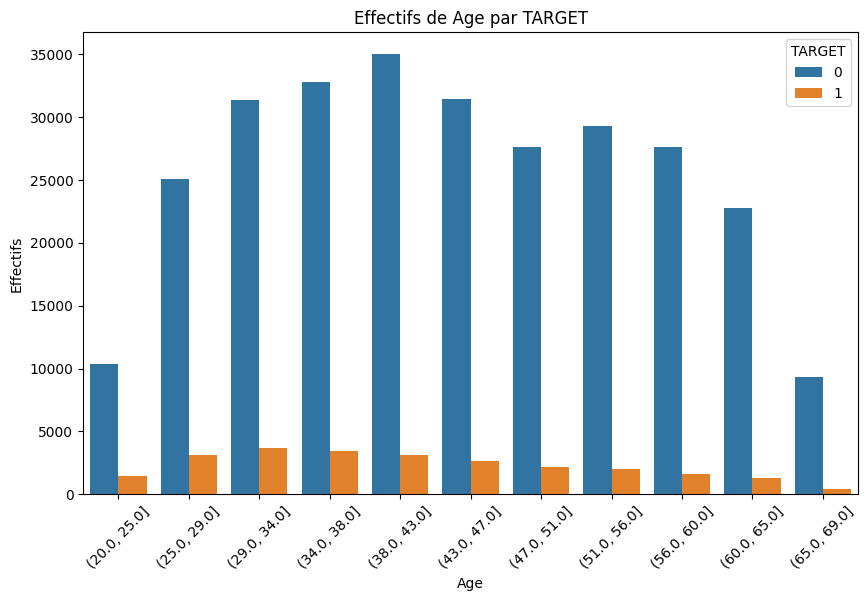

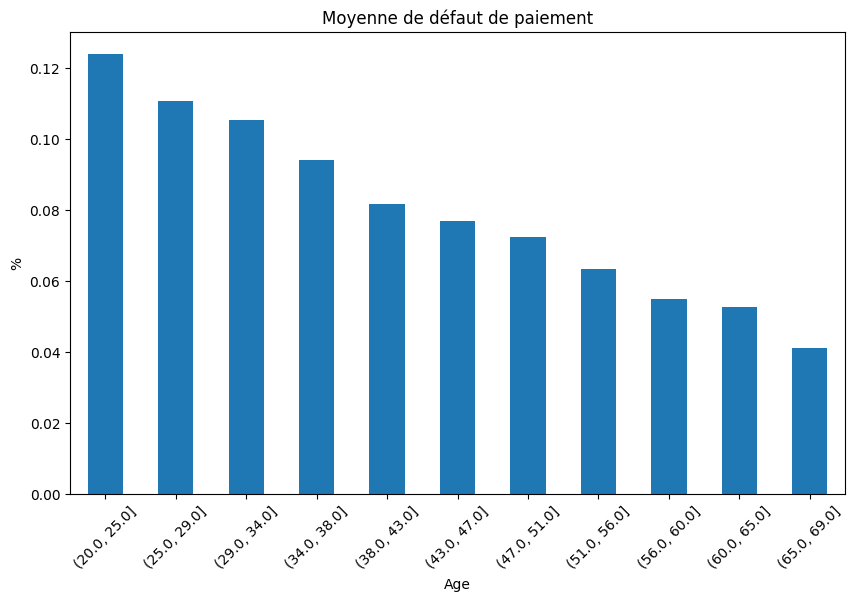

In [51]:
# Set the style of plots
age_data = app_train[['TARGET', 'DAYS_BIRTH']].copy()
age_data['Age'] = age_data['DAYS_BIRTH'] / 365

plot_target_num(age_data, 'Age')


Les jeunes sont plus susceptibles de ne pas rembourser le prêt. Le taux de défaut de remboursement est supérieur à 10 % pour les trois groupes d'âge les plus jeunes et inférieur à 5 % pour le groupe d'âge le plus âgé.

Enregistrons maintenant notre dataframe dans un fichier .csv afin d de pouvoir l'ouvrir sur le notebook de modélisation :

In [52]:
app_train.to_csv('app_train_clean.csv',index=False)